<a href="https://colab.research.google.com/github/Koutouf/FraudShield/blob/main/dftb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount("/content/mydrive")
import warnings

# Suppression de tous les avertissements pour un affichage plus clair des sorties
warnings.filterwarnings("ignore")

Mounted at /content/mydrive


In [12]:
import pandas as pd
import zipfile
# Chemin du fichier zip
data_path = "/content/mydrive/MyDrive/D_F_T_B/PS_20174392719_1491204439457_log.csv.zip"
# Extract the CSV file
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('/content')
    csv_newdata = zip_ref.namelist()[0]

In [18]:
from pyspark.sql import SparkSession

# Initialiser une session Spark
spark = SparkSession.builder \
    .appName("FraudDetection") \
    .getOrCreate()
data = spark.read.csv(f"/content/{csv_newdata}", header=True, inferSchema=True)
data.show(10, truncate=False)
data.printSchema()

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|type    |amount  |nameOrig   |oldbalanceOrg|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|1   |PAYMENT |9839.64 |C1231006815|170136.0     |160296.36     |M1979787155|0.0           |0.0           |0      |0             |
|1   |PAYMENT |1864.28 |C1666544295|21249.0      |19384.72      |M2044282225|0.0           |0.0           |0      |0             |
|1   |TRANSFER|181.0   |C1305486145|181.0        |0.0           |C553264065 |0.0           |0.0           |1      |0             |
|1   |CASH_OUT|181.0   |C840083671 |181.0        |0.0           |C38997010  |21182.0       |0.0           |1      |0             |
|1   |PAYMENT |11668.14|C2048537720|41554.0      |29885.86      |M1230701703|0.0   

In [19]:
# Schéma du dataset
data.printSchema()

# Statistiques descriptives
data.describe().show()

# Vérifier les valeurs manquantes
from pyspark.sql.functions import col, isnan, when, count

data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|           amount|   nameOrig|    oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+----

In [20]:
from pyspark.sql.functions import when
data = data.withColumn("label", when(data["isFraud"] == 1, 1).otherwise(0))
columns_to_drop = ["nameOrig", "nameDest"]
data = data.drop(*columns_to_drop)
data.show(5)


+----+--------+--------+-------------+--------------+--------------+--------------+-------+--------------+-----+
|step|    type|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|label|
+----+--------+--------+-------------+--------------+--------------+--------------+-------+--------------+-----+
|   1| PAYMENT| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|             0|    0|
|   1| PAYMENT| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|             0|    0|
|   1|TRANSFER|   181.0|        181.0|           0.0|           0.0|           0.0|      1|             0|    1|
|   1|CASH_OUT|   181.0|        181.0|           0.0|       21182.0|           0.0|      1|             0|    1|
|   1| PAYMENT|11668.14|      41554.0|      29885.86|           0.0|           0.0|      0|             0|    0|
+----+--------+--------+-------------+--------------+--------------+--------------+-------+-----

In [22]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import col
if "type_indexed" not in data.columns:
  indexer = StringIndexer(inputCol="type", outputCol="type_indexed")
  data = indexer.fit(data).transform(data)
data = data.withColumn("label", col("isFraud").cast("double"))
print(data.head())
data.show(5)
data.printSchema()
feature_columns = ["type_indexed", "amount", "oldbalanceOrg", "newbalanceOrig",
                   "oldbalanceDest", "newbalanceDest", "isFlaggedFraud"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data).select("features", "label")
print(assembler)
data.show(5)


Row(step=1, type='PAYMENT', amount=9839.64, oldbalanceOrg=170136.0, newbalanceOrig=160296.36, oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0, label=0.0, type_indexed=1.0)
+----+--------+--------+-------------+--------------+--------------+--------------+-------+--------------+-----+------------+
|step|    type|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|label|type_indexed|
+----+--------+--------+-------------+--------------+--------------+--------------+-------+--------------+-----+------------+
|   1| PAYMENT| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|             0|  0.0|         1.0|
|   1| PAYMENT| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|             0|  0.0|         1.0|
|   1|TRANSFER|   181.0|        181.0|           0.0|           0.0|           0.0|      1|             0|  1.0|         3.0|
|   1|CASH_OUT|   181.0|        181.0|           0.0

In [23]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

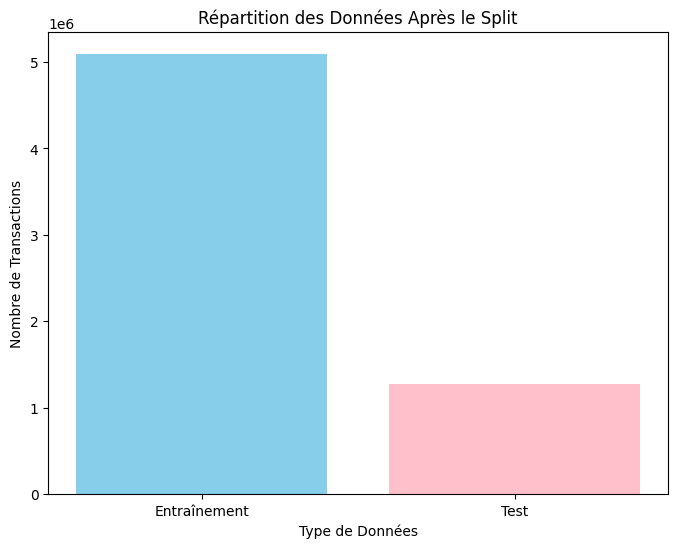

In [30]:
train_size = train_data.count()
test_size = test_data.count()
plt.figure(figsize=(8, 6))
plt.bar(["Entraînement", "Test"], [train_size, test_size], color=["skyblue", "pink"])
plt.title("Répartition des Données Après le Split")
plt.ylabel("Nombre de Transactions")
plt.xlabel("Type de Données")
plt.show()

In [24]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
# Créer le modèle
lr = LogisticRegression(featuresCol="features", labelCol="label")
model = lr.fit(data)

# Évaluer le modèle
predictions = model.transform(test_data)
predictions.select("label", "prediction", "probability").show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.99845243680165...|
|  0.0|       0.0|[0.99845251499591...|
|  0.0|       0.0|[0.99845252726132...|
|  0.0|       0.0|[0.99845258552068...|
|  0.0|       0.0|[0.99845265910832...|
+-----+----------+--------------------+
only showing top 5 rows



In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print(f"F1-Score : {f1_score}")


F1-Score : 0.9991664056206274


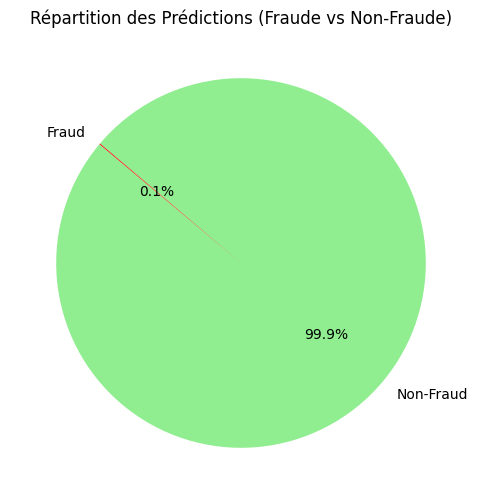

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir les données Spark en Pandas pour la visualisation
predictions_pd = predictions.select("label", "prediction").toPandas()

# Répartition des prédictions (fraude vs non-fraude)
plt.figure(figsize=(8, 6))
predictions_pd["prediction"].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=["Non-Fraud", "Fraud"],
    colors=["lightgreen", "red"],
    startangle=140
)
plt.title("Répartition des Prédictions (Fraude vs Non-Fraude)")
plt.ylabel("")  # Supprime l'étiquette par défaut
plt.show()
